In [1]:
import os
import healpy as hp
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from lenstools import ConvergenceMap
from astropy import units as u

In [2]:
from src.info_extractor import InfoExtractor
from src.patch_analyser import PatchAnalyser
from src.fullsky_analyser import FullSkyAnalyser
from analysis import KappaAnalyser
from src.patch_processor import PatchProcessor
from src.utils import load_config, filter_config, setup_logging

In [3]:
workdir = Path("/lustre/work/akira.tokiwa/Projects/LensingSSC")
config_file = workdir / "configs" / "config_default.yaml"
config = load_config(config_file)
setup_logging()
zs =2.0

In [10]:
patch_size = config["patch_size"]
nbin = config["nbin"]
bins = np.linspace(-4, 4, nbin+1, endpoint=True)
nu = (bins[1:] + bins[:-1]) / 2

In [5]:
sample_patch_tiled_path = list((workdir / "data" / "patches"/ "tiled"/ f"zs{zs}").glob(f"*.npy"))[1]
sample_patch_bigbox_path = list((workdir / "data" / "patches"/ "bigbox"/ f"zs{zs}").glob(f"*.npy"))[1]

In [6]:
sample_patch_tiled = np.load(sample_patch_tiled_path)
sample_patch_bigbox = np.load(sample_patch_bigbox_path)

In [7]:
# exclude index 130, 132, 134
sample_patch_tiled = np.delete(sample_patch_tiled, [130, 132, 134], axis=0)
sample_patch_bigbox = np.delete(sample_patch_bigbox, [130, 132, 134], axis=0)

In [8]:
conv_map_tiled = ConvergenceMap(sample_patch_tiled[0], angle=patch_size * u.deg).smooth(2.0 * u.arcmin)
conv_map_bigbox = ConvergenceMap(sample_patch_bigbox[0], angle=patch_size * u.deg).smooth(2.0 * u.arcmin)

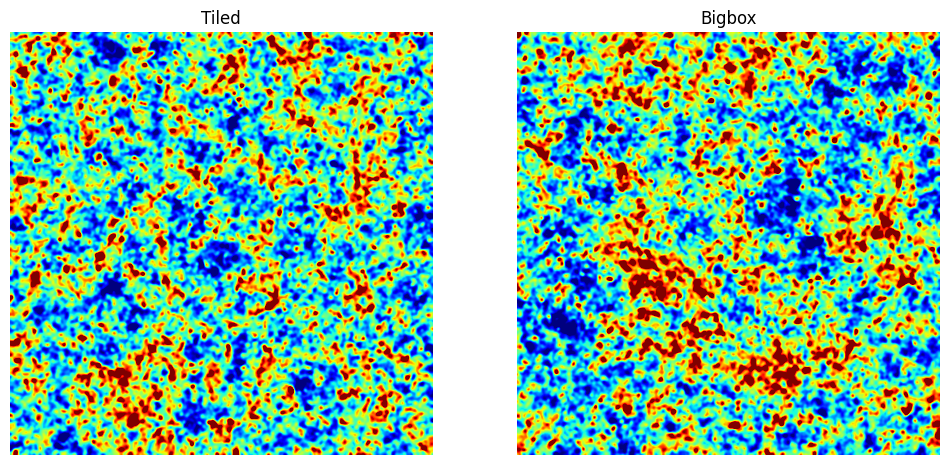

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(conv_map_tiled.data, cmap="jet", vmin=-0.032, vmax=0.032)
ax[0].set_title("Tiled")

ax[1].imshow(conv_map_bigbox.data, cmap="jet", vmin=-0.032, vmax=0.032)
ax[1].set_title("Bigbox")

for a in ax:
    a.axis("off")

plt.show()

In [30]:
pdf_tiled = []
for patch in sample_patch_tiled:
    conv_map = ConvergenceMap(patch, angle=patch_size * u.deg).smooth(2.0 * u.arcmin)
    pdf_tiled.append(conv_map.pdf(bins, norm=True)[1])
pdf_tiled = np.array(pdf_tiled)

pdf_bigbox = []
for patch in sample_patch_bigbox:
    conv_map = ConvergenceMap(patch, angle=patch_size * u.deg).smooth(2.0 * u.arcmin)
    pdf_bigbox.append(conv_map.pdf(bins, norm=True)[1])
pdf_bigbox = np.array(pdf_bigbox)

In [31]:
def normalize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

In [32]:
pdf_tiled_norm = normalize(pdf_tiled)
pdf_bigbox_norm = normalize(pdf_bigbox)

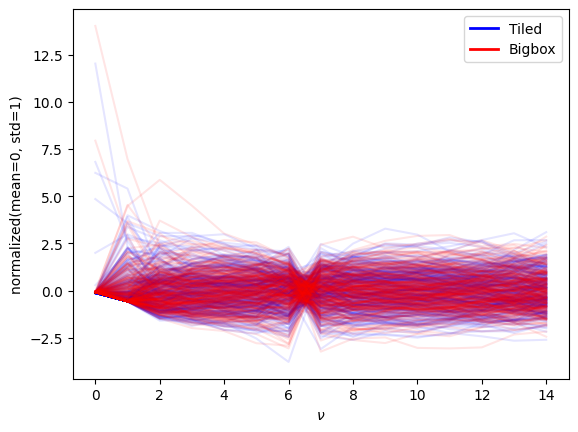

In [33]:
plt.plot(pdf_tiled_norm.T, color="blue", alpha=0.1)
plt.plot(pdf_bigbox_norm.T, color="red", alpha=0.1)

plt.legend([Line2D([0], [0], color="blue", lw=2), Line2D([0], [0], color="red", lw=2)], ["Tiled", "Bigbox"])

plt.xlabel(r"$\nu$")
plt.ylabel("normalized(mean=0, std=1)")
plt.show()

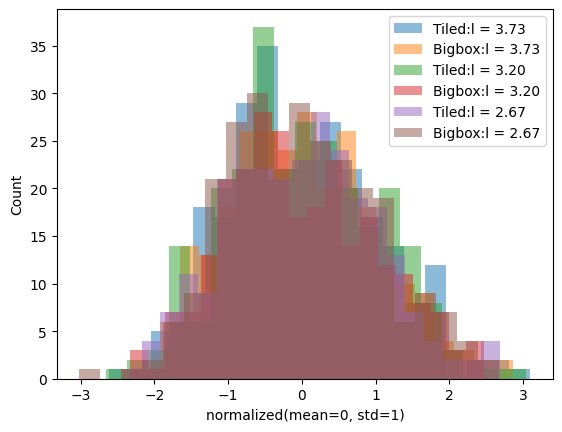

In [34]:
for i in range(1, 4):
    plt.hist(pdf_tiled_norm[:, -i], bins=20, alpha=0.5, label="Tiled:" + f"l = {nu[-i]:.2f}")
    plt.hist(pdf_bigbox_norm[:, -i], bins=20, alpha=0.5, label="Bigbox:" + f"l = {nu[-i]:.2f}")
plt.xlabel("normalized(mean=0, std=1)")
plt.ylabel("Count")
plt.legend()
plt.show()

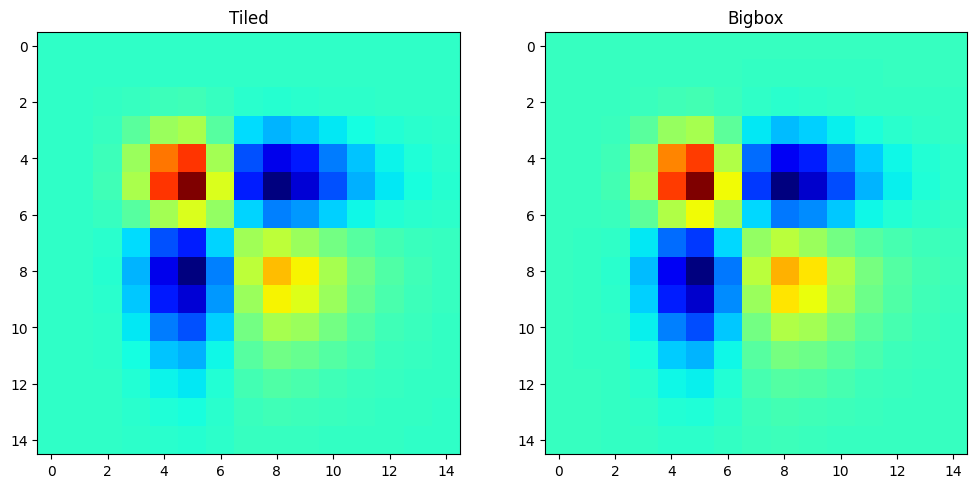

In [35]:
cov_tiled = np.cov(pdf_tiled.T)
cov_bigbox = np.cov(pdf_bigbox.T)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(cov_tiled, cmap="jet")
ax[0].set_title("Tiled")
ax[1].imshow(cov_bigbox, cmap="jet")
ax[1].set_title("Bigbox")

plt.show()

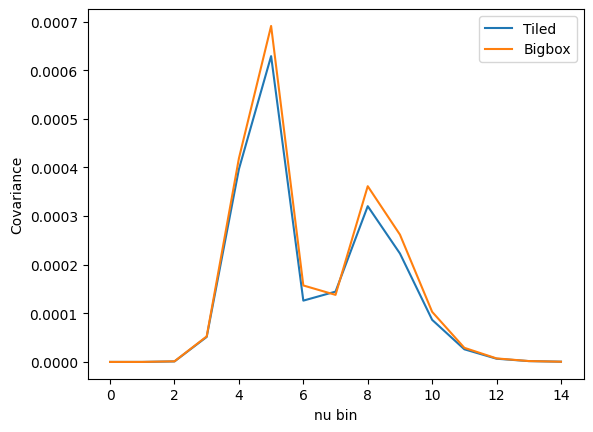

In [36]:
plt.plot(np.diag(cov_tiled), label="Tiled")
plt.plot(np.diag(cov_bigbox), label="Bigbox")
plt.legend()
plt.xlabel("nu bin")
plt.ylabel("Covariance")
plt.show()